# Generate polynomial features from minimal dataset

Load minimal project dataset as `data_dict`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import re

HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Desktop', 'raw_data', 'ml')

with open('data/final_project_dataset.pkl', 'r') as data_file:
    data_dict = pickle.load(data_file)

del data_dict['TOTAL']

In [29]:
all_keys = data_dict['METTS MARK'].keys()
all_keys.remove('email_address')
print 'Length of all_keys before moving poi', len(all_keys)
all_keys.insert(0, all_keys.pop(all_keys.index('poi')))
print 'Length of all_keys AFTER moving poi', len(all_keys)
print 'First item in all_keys: ', all_keys[0]

Length of all_keys before moving poi 20
Length of all_keys AFTER moving poi 20
First item in all_keys:  poi


In [30]:
from tools.feature_format import featureFormat

data = featureFormat(data_dict, all_keys, sort_keys=True, keep_keys=True)
keys, labels, features = data[:,0], data[:,1].astype(float), data[:, 2:].astype(float)
labels.shape, features.shape

((144,), (144, 19))

Scale features and add polynomial interaction features

In [31]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

scaler = StandardScaler()
polymaker = PolynomialFeatures(3)
scaled_features = scaler.fit_transform(features)
poly_features = polymaker.fit_transform(scaled_features)
poly_features.shape

(144, 1540)

Select the top 10% most significant features

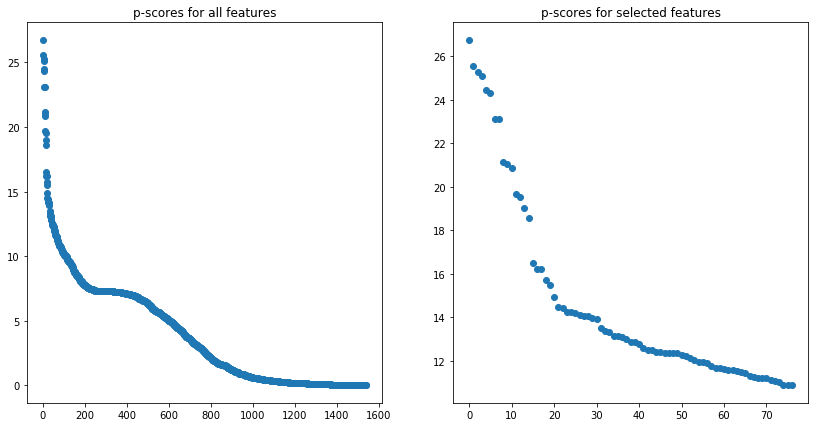

In [43]:
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=5)
selector.fit(poly_features, labels)
scores = selector.scores_
sorted_scores = sorted(scores, reverse=True)
x = range(len(scores))
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121, title='p-scores for all features')
ax1.scatter(x, sorted_scores)
mask = selector.get_support()
masked_scores = scores[mask]
masked_scores = sorted(masked_scores, reverse=True)
x = range(len(masked_scores))
ax2 = fig.add_subplot(122, title='p-scores for selected features')
ax2.scatter(x, masked_scores)
plt.show()

Create a dictionary of the selected features

In [44]:
sel_features =  selector.transform(poly_features)
poly_names = np.array(polymaker.get_feature_names(all_keys[1:]))
sel_poly_names = poly_names[mask]

In [46]:
poly_data = {}
for ik, key in enumerate(keys):
    poly_data[key] = {}
    poly_data[key]['poi'] = data_dict[key]['poi']
    for i, name in enumerate(sel_poly_names):
        poly_data[key][name] = float(sel_features[ik, i])

In [48]:
print 'poly_data length: ', len(poly_data),\
      ' compare with: ', len(data_dict) + 1 # +1 for TOTAL
print 'inner keys length: ', len(poly_data['METTS MARK']),\
      ' compare with: ', len(sel_poly_names) + 1 # +1 for 'poi'

poly_data length:  144  compare with:  146
inner keys length:  78  compare with:  78


Save new data dictionary as `poly_data.pkl` and a list of each person's keys as `poly_names.pkl`

In [50]:
poly_path = os.path.join(DATA_PATH, 'poly_data.pkl')
with open(poly_path, 'wb') as f:
    pickle.dump(poly_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
sel_poly_names = list(sel_poly_names)
sel_poly_names.insert(0, 'poi')
keys_path = os.path.join(DATA_PATH, 'poly_names.pkl')
with open(keys_path, 'wb') as f:
    pickle.dump(sel_poly_names, f, protocol=pickle.HIGHEST_PROTOCOL)